In [ ]:
import random

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history, reduce_automaton, to_automaton
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

random.seed(0)
torch.manual_seed(0)

In [ ]:
nonlinearity, lr, P, L, n_epochs = "tanh", 0.001, 100, 1, 2000

In [ ]:
def trial(gain, seq_len):
    ## Generate data

    # Define problem and data encoding
    symbols = [0, 1]
    encoding = OneHot(symbols)
    problem = lambda seq: np.sum(seq) % 2  # XOR problem

    # Define sequence lengths for training and validation datasets
    train_seq_lengths = list(range(1, seq_len + 1))
    analysis_seq_lengths = train_seq_lengths
    val_seq_length = 50
    val_datapoints = 100

    # Generate datasets
    training_datasets = [
        seq_data(device, problem, encoding, seq_len=length)
        for length in train_seq_lengths
    ]
    validation_datasets = [
        seq_data(
            device,
            problem,
            encoding,
            n_datapoints=val_datapoints,
            seq_len=val_seq_length,
        )
    ]
    analysis_data = [
        seq_data(device, problem, encoding, seq_len=length)
        for length in analysis_seq_lengths
    ]
    tracked_datasets = validation_datasets + analysis_data + training_datasets

    ## Instantiate model
    model = Model(
        encoding=encoding,
        input_size=2,
        output_size=2,
        hidden_dim=P,
        n_layers=L,
        device=device,
        nonlinearity=nonlinearity,
        gain=gain,
    )

    ## Setup compiler
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, amsgrad=True, weight_decay=0.01
    )
    compiler = Compiler(model, criterion, optimizer)
    # initial_hidden = model.init_hidden(batch_size=1)[-1]
    # hidden_function = lambda inputs: model(inputs)[1][-1]
    # output_function = lambda inputs: model(inputs)[0]
    compiler.trackers = {
        "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
        # "hidden": ActivationTracker(
        #     encoding,
        #     hidden_function,
        #     analysis_data,
        #     initial=lambda: initial_hidden,
        # ),
        # "output": ActivationTracker(encoding, output_function, analysis_data),
    }

    ## Training run
    compiler.training_run(
        training_datasets,
        n_epochs=n_epochs,
        batch_size=128,
    )

    ## Collect data
    loss = compiler.trackers["loss"].get_trace()
    val_loss = loss.query("Dataset==0")[0].to_numpy()[-1]
    train_loss = loss.query("Dataset>0").groupby("Epoch").mean()[-1]
    initial_hidden = model.init_hidden(batch_size=1)[-1]
    hidden_function = lambda inputs: model(inputs)[1][-1]
    output_function = lambda inputs: model(inputs)[0]
    automaton = to_automaton(
        hidden_function,
        output_function,
        initial_hidden,
        training_datasets,
        encoding,
        merge_distance_frac=0.1,
    )
    n_states = len(automaton.states)

    return train_loss, val_loss, n_states

In [18]:
N_gain, N_len = 10, 10

gains = np.linspace(0.1, 2.0, N_gain)
seq_lens = np.linspace(1, 10, N_len, dtype=int)
gain_data, seq_len_data, train_loss_data, val_loss_data, n_states_data = (
    [],
    [],
    [],
    [],
    [],
)

for gain in gains:
    for seq_len in seq_lens:

        # train_loss, val_loss, n_states = trial(gain, seq_len)
        train_loss, val_loss, n_states = (
            np.random.random(),
            np.random.random(),
            np.random.random(),
        )
        for data, item in zip(
            (gain_data, seq_len_data, train_loss_data, val_loss_data, n_states_data),
            (gain, seq_len, train_loss, val_loss, n_states),
        ):
            data.append(item)

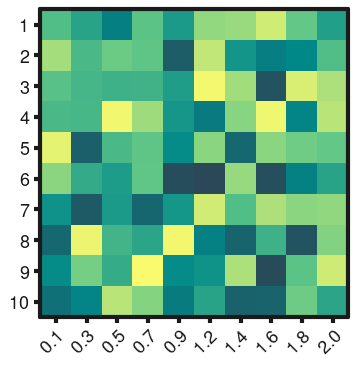

In [50]:
## Plot results
train_loss_grid = np.array(train_loss_data).reshape(N_gain, N_len)

fig = plt.figure(figsize=(4, 4))
publication.set_color_gradient(2)
plt.imshow(train_loss_grid)
publication.im_show(colorbar=False, x_labels=np.around(gains, 1), y_labels=seq_lens)